# **Engineering Probability and Statistics**

## **Computer Assignment 6**

**School of Electrical and Computer Engineering**  
**College of Engineering, University of Tehran**

**Instructors:** Dr. Bahrak, Dr. Vahhabi  
**Designers:** [Yasaman Amou Jafary](https://github.com/yasamanamoujafary), [Parsa Bukani](https://github.com/parsabukani)

**Topic:** Central Limit Theorem and Parameter Estimation

## **Table of Contents**

* **[Central Limit Theorem in Practice](#central-limit-theorem-in-practice)**

  * [Section 1: Skewed Daily Watch-Time Dataset](#section-1-skewed-daily-watch-time-dataset)

    * [Exploring the Dataset](#exploring-the-dataset)
    * [Section 1.1: Sample Means for Different Sample Sizes](#section-11-sample-means-for-different-sample-sizes)
    * [Section 1.2: Probability That the Sample Mean Lies in the Interval](#section-12-probability-that-the-sample-mean-lies-in-the-interval)
  * [Section 2: CLT for Simple Known Distributions](#section-2-clt-for-simple-known-distributions)

* **[Benford’s Law in Real-World Data](#benfords-law-in-real-world-data)**

  * [Section 1: Benford’s Law and the CLT Connection](#section-1-benfords-law-and-the-clt-connection)
  * [Section 2: Implementing Benford’s Law in R](#section-2-implementing-benfords-law-in-r)
  * [Section 3: Loading the Dataset and Constructing GDP](#section-3-loading-the-dataset-and-constructing-gdp)
  * [Section 4: Verifying Benford’s Law Using GDP](#section-4-verifying-benfords-law-using-gdp)

* **[Estimating MKG Café Busyness - Parameter Estimation](#mkg-parameter)**

  * [Setup](#setup)
  * [Section 1: One Observed Sample](#section-1-one-observed-sample)
  * [Section 2: Maximum Likelihood (ML) as a Curve](#section-2-maximum-likelihood-ml-as-a-curve)
  * [Section 3: ML Estimate from the Sample](#section-3-ml-estimate-from-the-sample)
  * [Section 4: What Happens When We Observe More Hours?](#section-4-what-happens-when-we-observe-more-hours)
  * [Section 5: True vs Estimated Distribution](#section-5-true-vs-estimated-distribution)

## **Central Limit Theorem in Practice**

### Section 1: SKEWED DAILY WATCH-TIME DATASET

#### Exploring the Dataset

In [56]:
set.seed(123)

n_users <- 5000

# Proportions of each user type
props <- c(light = 0.5, medium = 0.35, heavy = 0.15)

n_light  <- round(n_users * props["light"])
n_medium <- round(n_users * props["medium"])
n_heavy  <- n_users - n_light - n_medium

# Light users: mean 10, sd 4
light_users <- rnorm(n_light, mean = 10, sd = 4)

# Medium users: mean 40, sd 8
medium_users <- rnorm(n_medium, mean = 40, sd = 8)

# Heavy users: mean 90, sd 15
heavy_users <- rnorm(n_heavy, mean = 90, sd = 15)

watch_time <- c(light_users, medium_users, heavy_users)

# Truncate at 0 and 300 minutes to keep it realistic
watch_time[watch_time < 0] <- 0
watch_time[watch_time > 300] <- 300

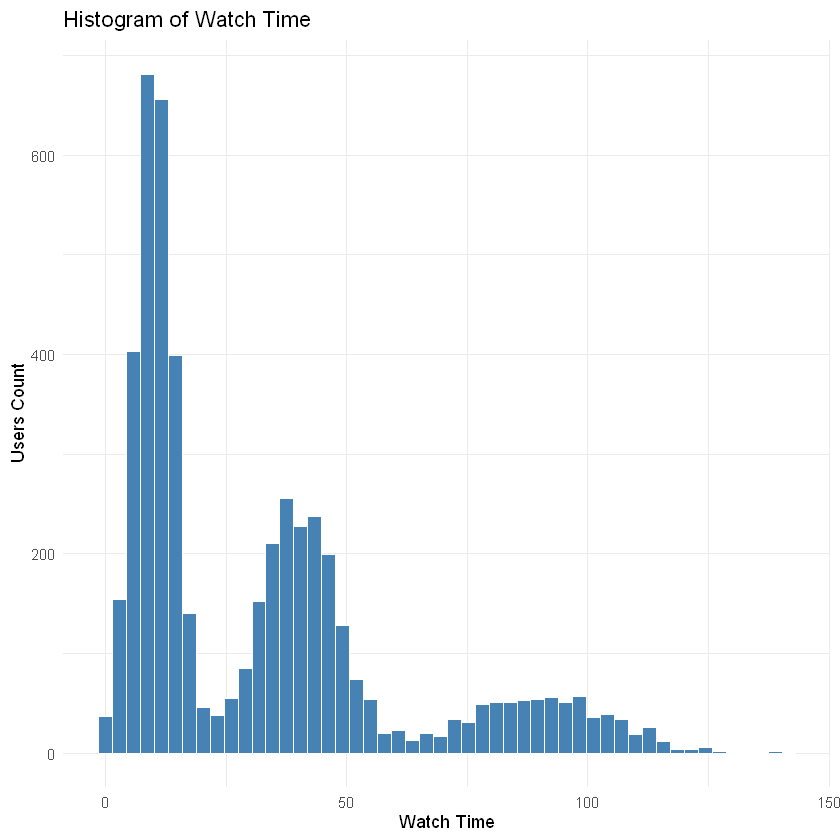

In [ ]:
# TODO: Plot a histogram of the original watch_time data.
library(ggplot2)

ggplot(
	data.frame(watch_time = watch_time),
	aes(x = watch_time)
	) +
geom_histogram(
	bins = 50,
	fill = "steelblue",
	color = "white"
) +
labs(
	title = "Histogram of Watch Time",
	x = "Watch Time",
	y = "Users Count"
) +
theme_minimal()



#### Section 1.1: Sample Means for Different Sample Sizes


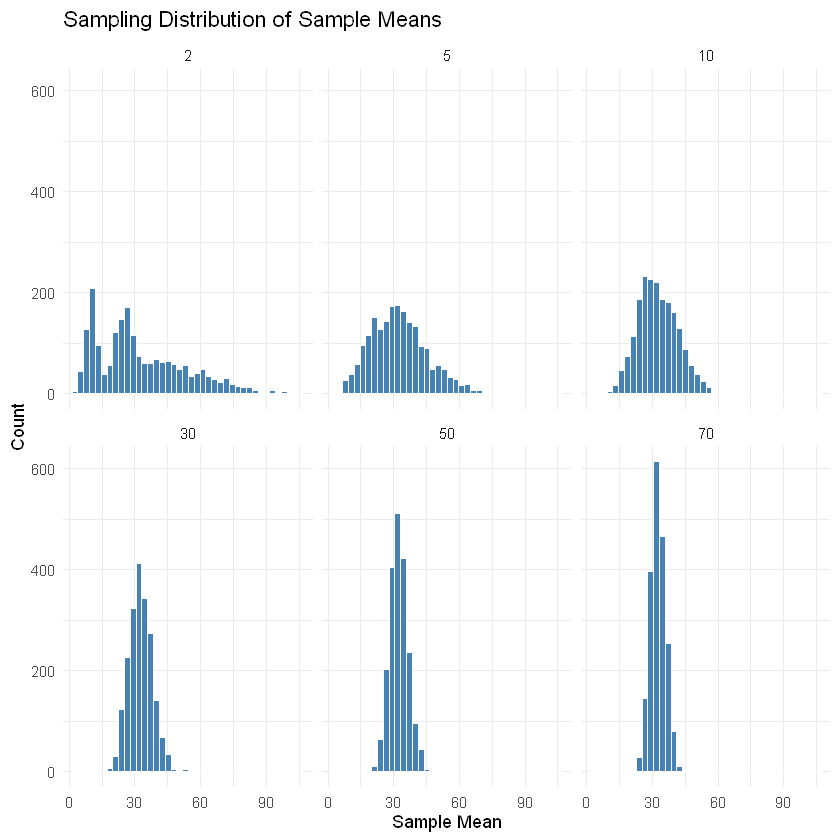

In [70]:
# Sample sizes to study
sample_sizes <- c(2, 5, 10, 30, 50, 70)
B <- 2000  # number of repetitions for each n

# TODO: generate sample means for each n
means <- numeric(0)
n_labels  <- numeric(0)

for (n in sample_sizes) {
  sample_means <- replicate(B, mean(sample(watch_time, size = n, replace = FALSE)))
  means <- c(means, sample_means)
  n_labels  <- c(n_labels, rep(n, B))
}

# TODO: Plot histograms of sample means for each n

df <- data.frame(
  mean = means,
  n = factor(n_labels, levels = sample_sizes)
)

x_limits <- range(df$mean)

ggplot(
	df,
	aes(x = mean)
) +
geom_histogram(
	bins = 40,
	fill = "steelblue",
	color = "white"
) +
facet_wrap(~ n, scales = "fixed") +
coord_cartesian(xlim = x_limits) +
labs(
	title = "Sampling Distribution of Sample Means",
	x = "Sample Mean",
	y = "Count"
) +
theme_minimal()


#### Section 1.2: Probability That the Sample Mean Lies in the Interval


In [71]:
set.seed(789)

# Estimate MU and SIGMA from WATCH_TIME

mu_hat    <- mean(watch_time)
sigma_hat <- sd(watch_time)

cat("Estimated mu (watch_time):", mu_hat,    "\n")
cat("Estimated sigma (watch_time):", sigma_hat, "\n")


# Choose a sample size n
n <- 36

# TODO: Compute the standard error sigma_bar = sigma_hat / sqrt(n),
#         then build the 95%-style CLT band around the mean:
#         [a, b] = [mu_hat - 2*sigma_bar, mu_hat + 2*sigma_bar].


# TODO: Using the CLT approximation X_bar ~ Normal(mu_hat, sigma_hat^2 / n),
#         compute the theoretical probability P(a < X_bar < b) using pnorm().


B <- 10000

# TODO: Estimate the same probability practically (simulation):
#         generate B sample means by resampling from watch_time,
#         then compute the fraction that falls inside [a, b].


# TODO: Visualize the simulated sample means with a density histogram
#         and mark the interval boundaries a and b with two vertical red lines.


Estimated mu (watch_time): 32.45821 


Estimated sigma (watch_time): 28.7749 


### Section 2: CLT for Simple Known Distributions

In Part 1, you saw that sample means from a messy, skewed “watch time” dataset became more and more bell‑shaped as the sample size increased. But maybe this was just a special case

In this part, you will:

Work with three simple, well‑known distributions:

- Uniform(0, 1)

- Exponential(rate = 1)

- Bernoulli(p = 0.3)

For each distribution:

- Generate raw data and plot its histogram to see the original shape.

- Generate many sample means for n = 5, 10, 30.

- Compare the histogram of the sample means with the theoretical normal curve predicted by the CLT:
mean = μ, variance = σ² / n.

In [ ]:
set.seed(456)

B <- 2000
n_values <- c(5, 10, 30, 50, 70)

# Distribution generators 
r_unif <- function(n) runif(n, min = 0, max = 1)
r_exp  <- function(n) rexp(n, rate = 1)
p_bern <- 0.3
r_bern <- function(n) rbinom(n, size = 1, prob = p_bern)

dist_list <- list(
  uniform     = r_unif,
  exponential = r_exp,
  bernoulli   = r_bern
)

# Theoretical mean (mu) and variance (sigma^2) for each distribution
dist_params <- list(
  uniform     = list(mu = 0.5, sigma2 = 1/12),
  exponential = list(mu = 1,   sigma2 = 1),
  bernoulli   = list(mu = p_bern,
                     sigma2 = p_bern * (1 - p_bern))
)

In [ ]:
# TODO: For each distribution, generate raw data and plot histogram
# IMPORTANT: Use the same x-axis limits for all histograms of a given distribution to allow proper comparison of variances.

## **Benford’s Law in Real-World Data**

### Section 1: Benford’s Law and the CLT connection


In this section you will:
1. Derive the Benford probability for the first digit:
$$
P(D=d)=\log_{10}\left(1+\frac{1}{d}\right),\quad d=1,\dots,9.
$$
2. Explain (conceptually) how the Central Limit Theorem (CLT) makes Benford’s law appear in real-world data.

TODO: ...

### Section 2: Implementing Benford’s Law in R

In this section, you will implement Benford’s Law in R.
First, you will write a function that returns the theoretical Benford probability for a given leading digit.  
Then, you will use this function to compute the probabilities for all digits and visualize the Benford distribution.

In [ ]:
# TODO: Define the Benford probability function
benford_prob <- function(n) {
  # do not forget to check that n is between 1 and 9
}

digits <- 1:9
probs <- NULL

# TODO: Plot the Benford distribution

### Section 3: Loading the Dataset and Constructing GDP

In this section, you will load a real-world dataset and construct a new variable using a meaningful economic relationship.
The dataset contains population and GDP per capita values for different countries and years. Using these variables, you will compute the total Gross Domestic Product (GDP) as:
$$
\text{GDP} = \text{population} \times \text{GDP per capita}.
$$
This constructed variable will later be used to study the distribution of leading digits and compare it with Benford’s Law. **Why can this be an appropriate variable to verify the Benford's law?** 

TODO: ... (answer to the question)

In [ ]:
# install the package for the first time only (uncomment the following code):
# install.packages("gapminder")

library(gapminder)
data <- gapminder

# TODO: Create a new column GDP

# Optional: Display the first few rows of the dataset

### Section 4: Verifying Benford’s Law Using GDP

In this section, you will empirically verify Benford’s Law using the GDP variable constructed in the previous section.
You will extract the leading digit of GDP values, compute the empirical distribution of leading digits, and **compare** it with the theoretical Benford distribution.

In [ ]:
# TODO: Function to extract leading digit
leading_digit <- function(x) {
  # remove non-positive or NA values
  # extract and return the first non-zero digit
}

# TODO: Extract leading digits from GDP
gdp_digits <- NULL

# TODO: Compute empirical distribution
empirical_freq <- NULL

# TODO: Plot empirical vs theoretical distributions

<a id="mkg-parameter"></a>
## **Estimating MKG Café Busyness - Parameter Estimation**

### Setup

In [ ]:
set.seed(7)

lambda_true <- 6  # hidden truth for simulation (customers/hour)

### Section 1: One observed sample

In [ ]:
# TODO: Generate one 24-hour sample of hourly counts (x_obs) and report its sample mean.

### Section 2: Maximum Likelihood (ML) as a curve

Instead of formulas, we’ll try many λ values and compute how plausible the observed data looks under each λ. The best λ is at the peak (maximum likelihood).

In [ ]:
# TODO:
# 1) Try λ values from 0.1 to 15 (with a small step) and compute how well the observed data fits each λ (log-likelihood).
# 2) Plot log-likelihood versus λ and find the λ where the curve reaches its maximum (this is the ML estimate).
# 3) Mark the sample mean on the same plot and write one sentence about whether it is close to the ML estimate.

### Section 3: ML estimate from the sample

For Poisson, the ML estimate equals the sample mean (your curve should peak right there).

In [ ]:
# TODO: Compute the ML estimate of λ directly from the observed sample, and report the estimated “average events per hour” as a single number.

### Section 4: What happens when we observe more hours?

Now we simulate repeated data collection. For each observation length, we repeat B = 1000 times to see the distribution of the estimate.

In [ ]:
# TODO:
# 1) Pick several observation lengths (from a few hours up to many days).
# 2) For each length, repeat the experiment 1000 times: generate hourly counts and compute one λ estimate each time.
# 3) Store all estimates so you can compare how “spread out” the estimates are for short vs long observation periods.


In [ ]:
# TODO:
# Simulate 1000 different evenings (4 hours each). For each evening, estimate λ from the 4 hourly counts.
# Then visualize how much the estimate changes from evening to evening (histogram + scatter plot),
# and report the average and standard deviation of these 1000 estimates. Mark the true λ on the plots.


In [ ]:
# TODO:
# Compare the λ estimates across different observation lengths by plotting them side-by-side.
# Use a boxplot (one box per observation length) to see how the spread shrinks as you observe more hours.
# Add a horizontal reference line for the true λ and write one sentence describing what changes as length increases.

In [ ]:
# TODO:
# For each observation length, compute how variable the λ estimates are (variance or SD across the 1000 repeats).
# Plot the variance versus the number of observed hours, and describe the trend in one clear sentence.

### Section 5: True vs Estimated distribution

In [ ]:
# TODO:
# Use the ML estimate of λ (λ̂ = the sample mean) and plot the Poisson PMF for:
# (1) the true λ and (2) the estimated λ̂ (MLE) on the same figure.